# Clasificación de imágenes por satelite con redes convolucionales

Con este Notebook se está empleando el transfer learning para la clasificación de imágenes mediante el entramiento de redes neuronales convolucionales.

En resumen, lo que se ha hecho ha sido primero entrenar un pequeño conjunto del dataset mezclado en una red convolucional preentrenada, y después se ha usado otro conjunto del dataset, que no ha visto la red, con intención de testearla para ver si aprende.

Se puede ver que la red que usamos para entrenar es una red preentrenada ya con un dataset de 1000 imágenes de partida, y además cada una de las capas conserva sus pesos en toda la ejecución, salvo la última que tiene pesos aleatorios y es la única que se entrena.


In [1]:
from __future__ import print_function, division
from contextlib import suppress
import matplotlib
import matplotlib.pyplot as plt

import os
import warnings
import time
import copy
from skimage.io import imread, imsave
from sklearn.metrics import accuracy_score, classification_report
%matplotlib inline


import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from zipfile import ZipFile


## Descargando Dataset y leyendo los datos

Para comenzar, lo primero que se necesita es descargar el dataset para tener datos con los que trabajar que se pueden descargar en "http://vision.ucmerced.edu/datasets/landuse.html". Lo siguiente será extraer dicho contenido, para ello se crea una carpeta "data", y a continuación extrae todos los datos ahí. Si todo esto ya existe este proceso no se realiza.

Por último, para saber si todo está correcto se comprueba mediante la reproducción de una imagen.

In [2]:
with suppress(FileExistsError):
    os.mkdir('data')

source_dir = os.path.join('data', 'UCMerced_LandUse', 'Images')

# Download the zipped dataset from http://vision.ucmerced.edu/datasets/landuse.html 
if not os.path.isdir(source_dir):
    with ZipFile('UCMerced_LandUse.zip') as z:
        z.extractall(path='data')

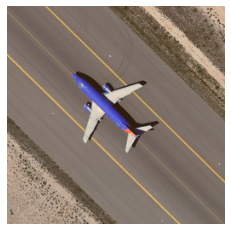

In [3]:
plt.imshow(imread('data/UCMerced_LandUse/Images/airplane/airplane78.tif'))
plt.axis('off')
plt.show()

## Creación de carpetas entrenamiento, test y validación, con imágenes aleatorias

Para obtener una red convolucional que tenga un buen comportamiento hay que hacer una división de la información del dataset. 
En este caso, lo que se hace es comprobar la ruta raíz del dataset, "/data/UCMerced_LandUse/Images", y comprueba si existe un directorio flow donde se han creado tres carpetas "train", "val" y "test", y si no es así se crearan dichas carpetas. 

Por último, se reparte la información mezclada entre estas tres carpetas de manera que a "train" le corresponde un 80%, a "validate un "10%" y a "test" otro "10%", guardando las imágenes de forma aleatoria, como PNGs ya que están en formato TIF.

In [4]:
"""
Create image directory hierarchy that looks like this:
./data/flow/
            train/
                  agriculture/
                  airplane/
                  ...
            validate/
                     agriculture/
                     airplane/
                     ...
            test/
                 agriculture/
                 airplane/
                 ...
"""
# We stablish the path to the images in source_dir
#source_dir = os.path.join('data', 'UCMerced_LandUse', 'Images')

# Collect class names from directory names in './data/UCMerced_LandUse/Images/'
class_names = os.listdir(source_dir)    

# Create path to image "flow" base directory, here we will make directories for the training process
flow_base = os.path.join('data', 'flow')

# Create pathnames to train/validate/test subdirectories
target_dirs = {target: os.path.join(flow_base, target) for target in ['train', 'validate', 'test']}
# If the directory is not present, the directories will be made
if not os.path.isdir(flow_base):

    # Make new directories
    os.mkdir(flow_base)
    
    # The first for-each will make the three dirctories, and for each directory, the classification directories will be also made
    for target in ['train', 'val', 'test']:
        target_dir = os.path.join(flow_base, target)
        os.mkdir(target_dir)
        for class_name in class_names:
            class_subdir = os.path.join(target_dir, class_name)
            os.mkdir(class_subdir)

    # suppress low-contrast warning from skimage.io.imsave
    warnings.simplefilter('ignore', UserWarning)
    
    # Copy images from ./data/UCMerced_LandUse/Images to ./data/flow/<train, validate, test>, each directory will have random amount of images  
    for root, _, filenames in os.walk(source_dir):
        if filenames:
            class_name = os.path.basename(root)

            # Randomly shuffle filenames
            filenames = np.random.permutation(filenames)
            for target, count in [('train', 80), ('val', 10), ('test', 10)]:
                target_dir = os.path.join(flow_base, target, class_name)
                for filename in filenames[:count]:
                    filepath = os.path.join(root, filename)
                    image = imread(filepath)
                    basename, _ = os.path.splitext(filename)
                    # Convert TIF to PNG to work with Keras ImageDataGenerator.flow_from_directory
                    target_filename = os.path.join(target_dir, basename + '.png')
                    imsave(target_filename, image)
            
                filenames = filenames[count:]
    
    # Show future warnings during development
    warnings.resetwarnings()

## Cargadores de datos

Para poder cargar todos los datos se utilizan los paquetes torchvision y torch.utils.data.

En este caso lo que se quiere conseguir es entrenar un modelo que pueda clasificar diversas imágenes que han sido captadas a través de un satelite. Para ello las diferentes imágenes para entrenamiento, validación y test, deben ser normalizadas a un estándar y ser mezcladas entre si.

Por otra parte, se deberá de comprobar si para todo el proceso se quiere usar una gráfica NVIDIA o la CPU.

In [5]:

# This normalization will make all data look the same for the sake of increase coherence and avoid data duplication
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/flow'
# All data images are loaded in image_dataset
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) 
                  # load and shuffle the data from train and val
                  for x in ['train', 'val']}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                             shuffle=True, num_workers=4)
               # this loads the size of the directory train and val
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Mostrar imágenes

Para poder ver las diferentes imágenes contenidas en el dataset primero hay que desnormalizarlas. 

A continuación, se define una función para mostrar imágenes, en la que las desnormaliza calculando la media y la varianza y se le aplica al estándar de normalización antes aplicado, al mostrar las imágenes se muestra la etiqueta de cada imagen. Como ejemplo se muestra cada una de las clases que hay en la carpeta "train", junto a una muestra de imagen.

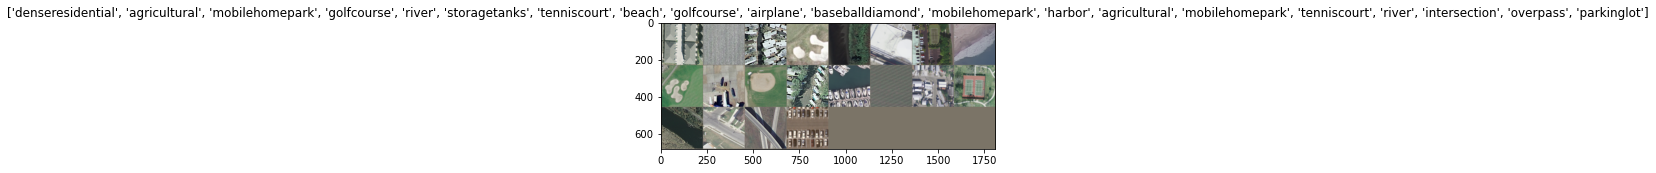

In [6]:

# Imshow transform the normalized data into images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Definición del entrenamiento del modelo

A continuación, se crea una función para poder entrenar la red de manera que en cada época se entrena el modelo y se valida, con el resultado de que se va quedando con el mejor modelo y se devolverá este, y planificando el learning rate, cuya variable "scheduler" es un planificador de learning rate obtenido de "torch.optim.lr_scheduler".

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Muestra de predicciones del modelo 

Lo siguiente será crear una función para poder comprobar que se realizan correctamente predicciones del modelo una vez se ha entrenado con un número de imágenes.

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Modelo con la última capa totalmente conectada 

A continuación se crea un modelo preentrenado, de manera que la última capa se establezca totalmente conectada. 

In [9]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 21.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Entrenamiento y evaluación

Por último, lo que queda es la ejecución, en el que se entrenará y evalurará la red, con la GPU tarda un minuto por época, y con una CPU tarda dos minutos por época.

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)


Epoch 0/9
----------
train Loss: 2.0115 Acc: 0.4857
val Loss: 0.7234 Acc: 0.8667

Training complete in 0m 22s
Epoch 1/9
----------
train Loss: 0.7938 Acc: 0.8071
val Loss: 0.2943 Acc: 0.9476

Training complete in 0m 43s
Epoch 2/9
----------
train Loss: 0.5153 Acc: 0.8768
val Loss: 0.1954 Acc: 0.9571

Training complete in 1m 5s
Epoch 3/9
----------
train Loss: 0.3891 Acc: 0.8994
val Loss: 0.1505 Acc: 0.9571

Training complete in 1m 29s
Epoch 4/9
----------
train Loss: 0.3222 Acc: 0.9131
val Loss: 0.1201 Acc: 0.9619

Training complete in 1m 54s
Epoch 5/9
----------
train Loss: 0.2989 Acc: 0.9196
val Loss: 0.0909 Acc: 0.9810

Training complete in 2m 19s
Epoch 6/9
----------
train Loss: 0.2622 Acc: 0.9321
val Loss: 0.0927 Acc: 0.9667

Training complete in 2m 40s
Epoch 7/9
----------
train Loss: 0.2392 Acc: 0.9327
val Loss: 0.0810 Acc: 0.9762

Training complete in 3m 1s
Epoch 8/9
----------
train Loss: 0.2296 Acc: 0.9429
val Loss: 0.0843 Acc: 0.9667

Training complete in 3m 21s
Epoch 9/9
--

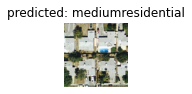

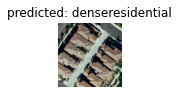

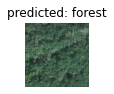

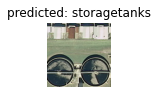

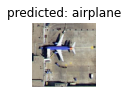

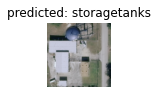

In [11]:
visualize_model(model_ft)
plt.ioff()
plt.show()

## Modelo extractor de funciones fijas

Para conseguir un modelo extractor de funciones fijas lo que se hace es obtener un modelo preentrenado al que se le congela toda la estructura de la red salvo la capa final, basicamente lo que se consigue con esto es que no se usen los gradientes, y por tanto, no sean calculados, salvo en la última capa que se añade además pesos aleatorios 

In [12]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Entrenando y evaluando 

Con este modelo anterior se consigue que en tanto en GPU como en CPU se ejecute en la mitad de tiempo que antes, esto se debe a que los gradientes de la mayoría de la red no son calculados.

In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.5239 Acc: 0.3048
val Loss: 1.6476 Acc: 0.6714

Training complete in 0m 10s
Epoch 1/24
----------
train Loss: 1.5468 Acc: 0.6583
val Loss: 1.0554 Acc: 0.7714

Training complete in 0m 23s
Epoch 2/24
----------
train Loss: 1.1764 Acc: 0.7488
val Loss: 0.7634 Acc: 0.8762

Training complete in 0m 35s
Epoch 3/24
----------
train Loss: 0.9520 Acc: 0.7946
val Loss: 0.5956 Acc: 0.9048

Training complete in 0m 47s
Epoch 4/24
----------
train Loss: 0.8223 Acc: 0.8268
val Loss: 0.5152 Acc: 0.9143

Training complete in 0m 56s
Epoch 5/24
----------
train Loss: 0.7426 Acc: 0.8286
val Loss: 0.4508 Acc: 0.9190

Training complete in 1m 5s
Epoch 6/24
----------
train Loss: 0.6882 Acc: 0.8387
val Loss: 0.4436 Acc: 0.9095

Training complete in 1m 14s
Epoch 7/24
----------
train Loss: 0.6668 Acc: 0.8411
val Loss: 0.4159 Acc: 0.9190

Training complete in 1m 23s
Epoch 8/24
----------
train Loss: 0.6729 Acc: 0.8405
val Loss: 0.4039 Acc: 0.9333

Training complete in 1m 32s
Ep

## Leer y predecir una imagen con el modelo entrenado 

Por último, se crea una función que con el modelo entrenado se le pasa una imagen que no haya visto todavía y la intente predecir. Para ello se utiliza el paquete PIL para leer dicha imagen. 

Para poder hacer este proceso hay que abrir la imagen, normalizarla, y por último pasársela al modelo entrenado para que la intente predecir y se muestra el resultado de esta predicción.

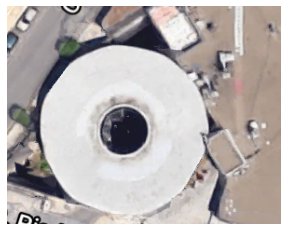

storagetanks


In [35]:
import PIL  
from PIL import Image

#given a image, pass it to the model and get the prediction
#008-021
#buenos 8-9-10-15-18-19-21
#contraejemplos 11-12-13-14-16-17-20
image = Image.open('/home/diegopc/Imágenes/Selección_014.png')
def predict(image):
    image = image.resize((224,224))
    image = np.array(image) / 255.0
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = (image - mean) / std 
    image = image.transpose((2,0,1))
    image = image.reshape(1,3,224,224).astype("float32")
    image = torch.from_numpy(image)
    image = image.to(device)
    model_conv.eval()
    with torch.no_grad():
        output = model_ft(image)
    _, predicted = torch.max(output.data, 1)
    return predicted

#run the prediction on the image
predicted = predict(image)
plt.imshow(image)
plt.axis('off')
plt.show()
print(class_names[predicted])
    
